<a href="https://colab.research.google.com/github/cppel/dz/blob/main/Task3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# распознавание образа

Три датасета

c = кошки
e = слоны
s = белки

In [1]:
# импортируем бэкенд Agg из matplotlib для сохранения графиков на диск
import matplotlib
matplotlib.use("Agg")

In [2]:
# Подключаем необходимые модули и пакеты
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers.core import Dense
from tensorflow.keras.optimizers import SGD
from tqdm.keras import TqdmCallback
from imutils import paths
import plotly.graph_objects as go
import numpy as np
import json
import random
import pickle
import cv2
import os

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1554775252050158207
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14343274496
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15252029728303443230
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [4]:
path = '/content/dataset/'

# Загрузка изображений

Начальная загрузка изображений
Просчитаем пути 

In [5]:
filtered_image_paths = filter(lambda x: 
                              'c' in x or 
                              'e' in x or
                              's' in x, paths.list_images(path))

imagePaths = sorted(list(filtered_image_paths))
print(imagePaths)
print("Total count: ", len(imagePaths))

random.shuffle(imagePaths)

['/content/dataset/c/1.jpeg', '/content/dataset/c/10.jpeg', '/content/dataset/c/100.jpeg', '/content/dataset/c/1001.jpeg', '/content/dataset/c/1002.jpeg', '/content/dataset/c/1004.jpeg', '/content/dataset/c/1005.jpeg', '/content/dataset/c/1006.jpeg', '/content/dataset/c/1007.jpeg', '/content/dataset/c/1008.jpeg', '/content/dataset/c/101.jpeg', '/content/dataset/c/1011.jpeg', '/content/dataset/c/1012.jpeg', '/content/dataset/c/1013.jpeg', '/content/dataset/c/1014.jpeg', '/content/dataset/c/1015.jpeg', '/content/dataset/c/1016.jpeg', '/content/dataset/c/1017.jpeg', '/content/dataset/c/1018.jpeg', '/content/dataset/c/1019.jpeg', '/content/dataset/c/1021.jpeg', '/content/dataset/c/1022.jpeg', '/content/dataset/c/1024.jpeg', '/content/dataset/c/1025.jpeg', '/content/dataset/c/1027.jpeg', '/content/dataset/c/1028.jpeg', '/content/dataset/c/1029.jpeg', '/content/dataset/c/103.jpeg', '/content/dataset/c/1030.jpeg', '/content/dataset/c/1032.jpeg', '/content/dataset/c/1033.jpeg', '/content/datas

In [6]:
from tqdm import tqdm

data = []
labels = []

for imagePath in tqdm(imagePaths, total=len(imagePaths)):

	image = cv2.imread(imagePath) # загружаем изображение
	image = cv2.resize(image, (64, 64)).flatten() # меняем его разрешение на 64x64 пикселей (без учета соотношения сторон),
																								# сглаживаем его в 64x64x3=12 288 пикселей
	data.append(image) # добавляем в список

	label = imagePath.split(os.path.sep)[-2] 	# извлекаем метку класса из пути к изображению (метка класса зависит от имени папки)
	labels.append(label) # обновляем список меток

100%|██████████| 3600/3600 [00:04<00:00, 834.80it/s]


Нормализация данных

In [7]:
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

Разбиваем данные на обучающую и тестовую выборки, используя 75%. Данных для обучения и оставшиеся 25% для тестирования

In [8]:
(trainX, testX, trainY, testY) = train_test_split(data,
	labels, test_size=0.25, random_state=42)

Конвертируем метки из целых чисел в векторы (для 2х классов при бинарной классификации вам следует использовать функцию Keras "to_categorical" вместо "LabelBinarizer" из scikit-learn, которая не возвращает вектор).

In [9]:
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

# Варианты нейронной сети
Методы для обработки

In [13]:
def trainModel(model, epochs, batch_size, opt):
	print("[INFO] training network...")
	model.compile(loss="categorical_crossentropy", optimizer=opt,
		metrics=["accuracy"])
	
	history = model.fit(trainX, trainY, validation_data=(testX, testY),
		epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[TqdmCallback(verbose=1)])

	return model, history

# Все картинки
image: 64x64x3 ALL IMAGES

In [16]:
from tensorflow.keras.optimizers import SGD

model = Sequential()
model.add(Dense(2048, input_shape=(12288,), activation="relu")) 
model.add(Dense(1024, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dense(len(lb.classes_), activation="softmax"))

# Скорость обучения
INIT_LR = 0.01

# Количество эпох
EPOCHS = 100

# Размер батча
BATCH_SIZE = 500

model, history = trainModel(model, EPOCHS, BATCH_SIZE, SGD(INIT_LR))

[INFO] training network...


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [17]:
fig = go.Figure()
	
for key, _ in history.history.items():
  fig.add_trace(go.Scattergl(y=history.history[key],
			     name=key))
fig.update_layout(height=500, width=700,
		   xaxis_title='Epoch',
		   yaxis_title='Loss')
  
fig.update_xaxes(range=[0, EPOCHS])
fig.update_yaxes(range=[0, 2])
fig.show()

In [18]:
from tensorflow.keras.optimizers import SGD

model = Sequential()
model.add(Dense(2048, input_shape=(12288,), activation="relu")) 
model.add(Dense(1024, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dense(len(lb.classes_), activation="softmax"))

# Скорость обучения
INIT_LR = 0.01

# Количество эпох
EPOCHS = 100

# Размер батча
BATCH_SIZE = 20

model, history = trainModel(model, EPOCHS, BATCH_SIZE, SGD(INIT_LR))

[INFO] training network...


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [19]:
fig = go.Figure()
	
for key, _ in history.history.items():
  fig.add_trace(go.Scattergl(y=history.history[key],
			     name=key))
fig.update_layout(height=500, width=700,
		   xaxis_title='Epoch',
		   yaxis_title='Loss')
  
fig.update_xaxes(range=[0, EPOCHS])
fig.update_yaxes(range=[0, 2])
fig.show()

In [20]:
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Dense(2048, input_shape=(12288,), activation="relu"))
model.add(Dense(1024, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dense(len(lb.classes_), activation="softmax"))

# Скорость обучения
INIT_LR = 0.01

# Количество эпох
EPOCHS = 50

# Размер батча
BATCH_SIZE = 400

model, history = trainModel(model, EPOCHS, BATCH_SIZE, Adam(INIT_LR))

[INFO] training network...


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [21]:
fig = go.Figure()
	
for key, _ in history.history.items():
  fig.add_trace(go.Scattergl(y=history.history[key],
			     name=key))
fig.update_layout(height=500, width=700,
		   xaxis_title='Epoch',
		   yaxis_title='Loss')
  
fig.update_xaxes(range=[0, EPOCHS])
fig.update_yaxes(range=[0, 2])
fig.show()

3 класса ~4000 картинок
'e'

'c'

's'

image: 64x64x3 ALL IMAGES

In [22]:
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Dense(2048, input_shape=(12288,), activation="relu"))
model.add(Dense(1024, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dense(len(lb.classes_), activation="softmax"))

# Скорость обучения
INIT_LR = 0.01

# Количество эпох
EPOCHS = 50

# Размер батча
BATCH_SIZE = 400

model, history = trainModel(model, EPOCHS, BATCH_SIZE, Adam(INIT_LR))

[INFO] training network...


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [23]:
fig = go.Figure()
	
for key, _ in history.history.items():
  fig.add_trace(go.Scattergl(y=history.history[key],
			     name=key))
fig.update_layout(height=500, width=700,
		   xaxis_title='Epoch',
		   yaxis_title='Loss')
  
fig.update_xaxes(range=[0, EPOCHS])
fig.update_yaxes(range=[0, 2])
fig.show()

In [24]:
from tensorflow.keras.optimizers import Adadelta

model = Sequential()
model.add(Dense(2048, input_shape=(12288,), activation="relu"))
model.add(Dense(1024, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dense(len(lb.classes_), activation="softmax"))

# Скорость обучения
INIT_LR = 0.005

# Количество эпох
EPOCHS = 30

# Размер батча
BATCH_SIZE = 200

model, history = trainModel(model, EPOCHS, BATCH_SIZE, Adadelta(INIT_LR))

[INFO] training network...


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [25]:
fig = go.Figure()
	
for key, _ in history.history.items():
  fig.add_trace(go.Scattergl(y=history.history[key],
			     name=key))
fig.update_layout(height=500, width=700,
		   xaxis_title='Epoch',
		   yaxis_title='Loss')
  
fig.update_xaxes(range=[0, EPOCHS])
fig.update_yaxes(range=[0, 2])
fig.show()

In [26]:
from tensorflow.keras.optimizers import Adadelta

model = Sequential()
model.add(Dense(2048, input_shape=(12288,), activation="relu"))
model.add(Dense(1024, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dense(len(lb.classes_), activation="softmax"))

# Скорость обучения
INIT_LR = 0.005

# Количество эпох
EPOCHS = 35

# Размер батча
BATCH_SIZE = 200

model, history = trainModel(model, EPOCHS, BATCH_SIZE, Adadelta(INIT_LR))

[INFO] training network...


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [27]:
fig = go.Figure()
	
for key, _ in history.history.items():
  fig.add_trace(go.Scattergl(y=history.history[key],
			     name=key))
fig.update_layout(height=500, width=700,
		   xaxis_title='Epoch',
		   yaxis_title='Loss')
  
fig.update_xaxes(range=[0, EPOCHS])
fig.update_yaxes(range=[0, 2])
fig.show()

In [28]:
from tensorflow.keras.optimizers import Adadelta

model = Sequential()
model.add(Dense(2048, input_shape=(12288,), activation="relu"))
model.add(Dense(1024, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dense(len(lb.classes_), activation="softmax"))

# Скорость обучения
INIT_LR = 0.005

# Количество эпох
EPOCHS = 35

# Размер батча
BATCH_SIZE = 200

model, history = trainModel(model, EPOCHS, BATCH_SIZE, Adadelta(INIT_LR))

[INFO] training network...


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [29]:
fig = go.Figure()
	
for key, _ in history.history.items():
  fig.add_trace(go.Scattergl(y=history.history[key],
			     name=key))
fig.update_layout(height=500, width=700,
		   xaxis_title='Epoch',
		   yaxis_title='Loss')
  
fig.update_xaxes(range=[0, EPOCHS])
fig.update_yaxes(range=[0, 2])
fig.show()

In [31]:
print("[INFO] serializing network and label binarizer...")
model.save("model.h5", save_format="h5")
f = open("label_bin", "wb")
f.write(pickle.dumps(lb))
f.close()

[INFO] serializing network and label binarizer...


In [32]:
from keras.models import load_model
from keras import models    
from IPython.display import Image
import matplotlib.pyplot as plt
import argparse
import pickle
import cv2

In [33]:
# загружаем модель и бинаризатор меток
print("[INFO] loading network and label binarizer...")
model = models.load_model("model.h5")
lb = pickle.loads(open("label_bin", "rb").read())

[INFO] loading network and label binarizer...


In [34]:
def predict_image(imagepath, model, labels):
    image = cv2.imread(imagepath)
    output = image.copy()

    image = cv2.resize(image, (64, 64))
    # "Выравниваем" изображение (преобразуем его в вектор. Из 32х32х3 -> 3072)
    image = image.flatten()
    # масштабируем значения пикселей к диапазону [0, 1]
    image = image.astype("float") / 255.0
    image = image.reshape((1, image.shape[0]))

    # делаем предсказание на изображении
    preds = model.predict(image)

    predsList = preds.tolist()[0]
    for i in range(len(predsList)):
        print(f'{labels.classes_[i]:20} - {predsList[i]}')

    # находим индекс метки класса с наибольшей вероятностью
    # соответствия
    i = preds.argmax(axis=1)[0]
    label = labels.classes_[i]

    
    # Добавляем на исходное изображение метку класса и вероятность прогноза
    text = "{}: {:.2f}%".format(label, preds[0][i] * 100)
    cv2.putText(output, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7,
    	(0, 0, 255), 2)
    
    cv2.imwrite('output.jpg', output)

In [ ]:
def predict(imagepath, model):
    image = cv2.imread(imagepath)
    image = cv2.resize(image, (64, 64))
    image = image.flatten()
    image = image.astype("float") / 255.0
    image = image.reshape((1, image.shape[0]))

    return model.predict(image)

In [ ]:
test_data = {
    'c': [
        '/content/dataset/test/c/1.jpeg',
        '/content/dataset/test/c/2.jpeg',
        '/content/dataset/test/c/3.jpeg',
        '/content/dataset/test/c/4.jpeg',
        '/content/dataset/test/c/5.jpeg'
    ],

    'e': [
        '/content/dataset/test/e/1.jpg',
        '/content/dataset/test/e/2.jpg',
        '/content/dataset/test/e/3.jpg',
        '/content/dataset/test/e/4.jpg',
        '/content/dataset/test/e/5.jpg'
    ],

    's': [
        '/content/dataset/test/s/1.jpg',
        '/content/dataset/test/s/2.jpg',
        '/content/dataset/test/s/3.jpg',
        '/content/dataset/test/s/4.jpg',
        '/content/dataset/test/s/5.jpg'
    ]
}

In [ ]:
lb.classes_

array(['c', 'e', 's'], dtype='<U1')

In [ ]:
for label in lb.classes_:
    test_images = test_data[label]
    
    print(label)

    for image in test_images:
        prediction = predict(image, model)

        i = prediction.argmax(axis=1)[0]
        predicted_label = lb.classes_[i]

        if predicted_label != label:
            print(f'❌ - {label:20} - {predicted_label:20} - {prediction[0][i]}')
        else:
            print(f'✔️ - {label:20} - {predicted_label:20} - {prediction[0][i]}')

c
1/1 [==============================] - 0s 34ms/step
✔️ - c                    - c                    - 0.7575520277023315
1/1 [==============================] - 0s 35ms/step
✔️ - c                    - c                    - 0.4747411012649536
1/1 [==============================] - 0s 36ms/step
❌ - c                    - s                    - 0.6680339574813843
1/1 [==============================] - 0s 36ms/step
❌ - c                    - e                    - 0.4993409216403961
1/1 [==============================] - 0s 35ms/step
✔️ - c                    - c                    - 0.6367554068565369
e
1/1 [==============================] - 0s 33ms/step
✔️ - e                    - e                    - 0.8813230991363525
1/1 [==============================] - 0s 38ms/step
✔️ - e                    - e                    - 0.9499130249023438
1/1 [==============================] - 0s 35ms/step
✔️ - e                    - e                    - 0.9239687919616699
1/1 [=================

1/1 [==============================] - 0s 43ms/step
c                    - 0.6367554068565369
e                    - 0.037003692239522934
s                    - 0.3262408971786499


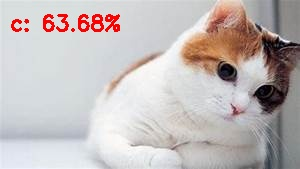

In [ ]:
predict_image('/content/dataset/test/c/5.jpeg', model, lb)
Image('output.jpg')